In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Bidirectional, Conv1D, MaxPooling1D, Flatten, Dropout

# To store model results
results = {}

# Load the dataset
try:
    df = pd.read_csv('nifty50_index_data_2010_2023.csv', index_col=0, parse_dates=True, header=[0,1])
    df.columns = df.columns.get_level_values(0)
    if 'Adj Close' in df.columns:
        df = df.drop(columns=['Adj Close'])
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: 'nifty50_index_data_2010_2023.csv' not found.")
    df = pd.DataFrame()

# Feature Engineering (Simple Lag Feature)
df['Close_Lag1'] = df['Close'].shift(1)
df.dropna(inplace=True)

# Splitting the data
train_df = df['2010-01-01':'2021-12-31']
test_df = df['2022-01-01':'2023-12-31']

X_train = train_df[['Close_Lag1']]
y_train = train_df['Close']
X_test = test_df[['Close_Lag1']]
y_test = test_df['Close']

# Scaling the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# We scale the target variable separately for neural networks
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))


print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Data loaded successfully.
Training data shape: (2940, 1)
Testing data shape: (493, 1)


### 1. Linear Regression
A basic model that finds a linear relationship between the input features and the stock price.

In [2]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

results['Linear Regression'] = {
    'MSE': mean_squared_error(y_test, y_pred_lr),
    'MAE': mean_absolute_error(y_test, y_pred_lr),
    'R2': r2_score(y_test, y_pred_lr)
}
print(f"Linear Regression MSE: {results['Linear Regression']['MSE']}")

# Plotting
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=y_test.index, y=y_pred_lr, mode='lines', name='Predicted'))
fig.update_layout(title='Linear Regression: Actual vs. Predicted', template='plotly_dark')
fig.show()

Linear Regression MSE: 23981.09028276065


### 2. Support Vector Machine (SVM)
A more complex model that can find non-linear relationships.

In [3]:
from sklearn.svm import SVR

svm_model = SVR(kernel='rbf')
svm_model.fit(X_train_scaled, y_train) # SVM can be trained on unscaled target
y_pred_svm = svm_model.predict(X_test_scaled)

results['SVM'] = {
    'MSE': mean_squared_error(y_test, y_pred_svm),
    'MAE': mean_absolute_error(y_test, y_pred_svm),
    'R2': r2_score(y_test, y_pred_svm)
}
print(f"SVM MSE: {results['SVM']['MSE']}")

# Plotting
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=y_test.index, y=y_pred_svm, mode='lines', name='Predicted'))
fig.update_layout(title='SVM: Actual vs. Predicted', template='plotly_dark')
fig.show()

SVM MSE: 91600411.51617074


### 3. Random Forest
An ensemble model that combines multiple decision trees to make more accurate predictions.

In [4]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

results['Random Forest'] = {
    'MSE': mean_squared_error(y_test, y_pred_rf),
    'MAE': mean_absolute_error(y_test, y_pred_rf),
    'R2': r2_score(y_test, y_pred_rf)
}
print(f"Random Forest MSE: {results['Random Forest']['MSE']}")

# Plotting
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=y_test.index, y=y_pred_rf, mode='lines', name='Predicted'))
fig.update_layout(title='Random Forest: Actual vs. Predicted', template='plotly_dark')
fig.show()

Random Forest MSE: 664782.8462962687


### 4. Recurrent Neural Network (RNN)
A type of neural network designed to work with sequential data like time-series stock prices.

In [5]:
# Reshape data for RNN
X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

rnn_model = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    Dense(1)
])
rnn_model.compile(optimizer='adam', loss='mse')
rnn_model.fit(X_train_rnn, y_train_scaled, epochs=50, batch_size=32, verbose=0)

y_pred_rnn_scaled = rnn_model.predict(X_test_rnn)
y_pred_rnn = y_scaler.inverse_transform(y_pred_rnn_scaled)

results['RNN'] = {
    'MSE': mean_squared_error(y_test, y_pred_rnn),
    'MAE': mean_absolute_error(y_test, y_pred_rnn),
    'R2': r2_score(y_test, y_pred_rnn)
}
print(f"RNN MSE: {results['RNN']['MSE']}")

# Plotting
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=y_test.index, y=y_pred_rnn.flatten(), mode='lines', name='Predicted'))
fig.update_layout(title='RNN: Actual vs. Predicted', template='plotly_dark')
fig.show()

C:\Users\amart\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
RNN MSE: 42748.30454913211
RNN MSE: 42748.30454913211


### 5. Long Short-Term Memory (LSTM)
An advanced type of RNN that can learn long-term dependencies in the data.

In [6]:
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_rnn, y_train_scaled, epochs=50, batch_size=32, verbose=0)

y_pred_lstm_scaled = lstm_model.predict(X_test_rnn)
y_pred_lstm = y_scaler.inverse_transform(y_pred_lstm_scaled)

results['LSTM'] = {
    'MSE': mean_squared_error(y_test, y_pred_lstm),
    'MAE': mean_absolute_error(y_test, y_pred_lstm),
    'R2': r2_score(y_test, y_pred_lstm)
}
print(f"LSTM MSE: {results['LSTM']['MSE']}")

# Plotting
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=y_test.index, y=y_pred_lstm.flatten(), mode='lines', name='Predicted'))
fig.update_layout(title='LSTM: Actual vs. Predicted', template='plotly_dark')
fig.show()

C:\Users\amart\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
LSTM MSE: 25652.09086821674
LSTM MSE: 25652.09086821674


### 6. Bidirectional Long Short-Term Memory (BiLSTM)
An extension of LSTM that processes the data in both forward and backward directions, potentially capturing more patterns.

In [7]:
bilstm_model = Sequential([
    Bidirectional(LSTM(50, activation='relu'), input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    Dense(1)
])
bilstm_model.compile(optimizer='adam', loss='mse')
bilstm_model.fit(X_train_rnn, y_train_scaled, epochs=50, batch_size=32, verbose=0)

y_pred_bilstm_scaled = bilstm_model.predict(X_test_rnn)
y_pred_bilstm = y_scaler.inverse_transform(y_pred_bilstm_scaled)

results['BiLSTM'] = {
    'MSE': mean_squared_error(y_test, y_pred_bilstm),
    'MAE': mean_absolute_error(y_test, y_pred_bilstm),
    'R2': r2_score(y_test, y_pred_bilstm)
}
print(f"BiLSTM MSE: {results['BiLSTM']['MSE']}")

# Plotting
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=y_test.index, y=y_pred_bilstm.flatten(), mode='lines', name='Predicted'))
fig.update_layout(title='Bidirectional LSTM: Actual vs. Predicted', template='plotly_dark')
fig.show()

C:\Users\amart\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
BiLSTM MSE: 24830.812217242335
BiLSTM MSE: 24830.812217242335


### 7. LightGBM
A gradient-boosting framework that is known for its speed and accuracy.

In [8]:
import lightgbm as lgb
lgbm_model = lgb.LGBMRegressor(random_state=42)
lgbm_model.fit(X_train, y_train)
y_pred_lgbm = lgbm_model.predict(X_test)

results['LightGBM'] = {
    'MSE': mean_squared_error(y_test, y_pred_lgbm),
    'MAE': mean_absolute_error(y_test, y_pred_lgbm),
    'R2': r2_score(y_test, y_pred_lgbm)
}
print(f"LightGBM MSE: {results['LightGBM']['MSE']}")

# Plotting
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=y_test.index, y=y_pred_lgbm, mode='lines', name='Predicted'))
fig.update_layout(title='LightGBM: Actual vs. Predicted', template='plotly_dark')
fig.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 2940, number of used features: 1
[LightGBM] [Info] Start training from score 8742.178742
LightGBM MSE: 919074.2566344404


C:\Users\amart\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning:

Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.

  File "C:\Users\amart\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.305

### 8. CNN-LSTM
A hybrid model that uses a CNN to extract features and an LSTM to make predictions based on those features.

In [9]:
from tensorflow.keras.layers import Input, Reshape
from tensorflow.keras import Model

# Fix CNN-LSTM model - reshape input for proper handling of 1D input
# For CNN-LSTM, we need to ensure data has proper dimensions for CNN layer

# Check shape of input data first
print(f"X_train_rnn shape: {X_train_rnn.shape}")

# Define the CNN-LSTM model
cnn_lstm_model = Sequential([
    # Conv1D requires (samples, timesteps, features)
    Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    # Keep pooling size as 1 to not reduce dimensions too much for small sequence
    MaxPooling1D(pool_size=1),
    LSTM(50, activation='relu', return_sequences=False),
    Dense(1)
])
cnn_lstm_model.compile(optimizer='adam', loss='mse')

# Print model summary to confirm architecture
cnn_lstm_model.summary()

# Fit the model
cnn_lstm_model.fit(X_train_rnn, y_train_scaled, epochs=50, batch_size=32, verbose=0)

y_pred_cnn_lstm_scaled = cnn_lstm_model.predict(X_test_rnn)
y_pred_cnn_lstm = y_scaler.inverse_transform(y_pred_cnn_lstm_scaled)

results['CNN-LSTM'] = {
    'MSE': mean_squared_error(y_test, y_pred_cnn_lstm),
    'MAE': mean_absolute_error(y_test, y_pred_cnn_lstm),
    'R2': r2_score(y_test, y_pred_cnn_lstm)
}
print(f"CNN-LSTM MSE: {results['CNN-LSTM']['MSE']}")

# Plotting
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=y_test.index, y=y_pred_cnn_lstm.flatten(), mode='lines', name='Predicted'))
fig.update_layout(title='CNN-LSTM: Actual vs. Predicted', template='plotly_dark')
fig.show()

X_train_rnn shape: (2940, 1, 1)


C:\Users\amart\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 64)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,179 (90.54 KB)

 Trainable params: 23,179 (90.54 KB)

 Non-trainable params: 0 (0.00 B)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
CNN-LSTM MSE: 31221.190944495596
CNN-LSTM MSE: 31221.190944495596


### 9. BiLSTM-BO-LightGBM
This is a more complex, conceptual model. A true implementation would involve using Bayesian Optimization (BO) to tune the hyperparameters of a BiLSTM, and then using the output of the BiLSTM as a feature in a LightGBM model. For simplicity, we'll just use the predictions of the BiLSTM as a feature.

In [10]:
# This is a conceptual model, where embeddings from BiLSTM could be used as features for LightGBM
bilstm_lgbm_model = lgb.LGBMRegressor(random_state=42)

# Create new feature set for LightGBM
X_train_bilstm_lgbm = X_train.copy()
X_train_bilstm_lgbm['bilstm_pred'] = y_scaler.inverse_transform(bilstm_model.predict(X_train_rnn))

X_test_bilstm_lgbm = X_test.copy()
X_test_bilstm_lgbm['bilstm_pred'] = y_pred_bilstm.flatten()

bilstm_lgbm_model.fit(X_train_bilstm_lgbm, y_train)
y_pred_bilstm_lgbm = bilstm_lgbm_model.predict(X_test_bilstm_lgbm)

results['BiLSTM-LightGBM'] = {
    'MSE': mean_squared_error(y_test, y_pred_bilstm_lgbm),
    'MAE': mean_absolute_error(y_test, y_pred_bilstm_lgbm),
    'R2': r2_score(y_test, y_pred_bilstm_lgbm)
}
print(f"BiLSTM-LightGBM MSE: {results['BiLSTM-LightGBM']['MSE']}")

# Plotting
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=y_test.index, y=y_pred_bilstm_lgbm, mode='lines', name='Predicted'))
fig.update_layout(title='BiLSTM-LightGBM: Actual vs. Predicted', template='plotly_dark')
fig.show()

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 2940, number of used features: 2
[LightGBM] [Info] Start training from score 8742.178742
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 2940, number of used features: 2
[LightGBM] [Info] Start training from score 8742.178742
BiLSTM-LightGBM MSE: 919074.2566344404
BiLSTM-LightGBM MSE: 919074.2566344404


### 10. ARIMA (Autoregressive Integrated Moving Average)
A classical time series forecasting model that combines autoregression, differencing, and moving average components to model temporal structures in the data.

Implementing ARIMA model...
Train data shape: (2940, 6)
Test data shape: (493, 6)
Train data index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Train data time range: 2010-01-05 00:00:00 to 2021-12-31 00:00:00
Test data time range: 2022-01-03 00:00:00 to 2023-12-29 00:00:00


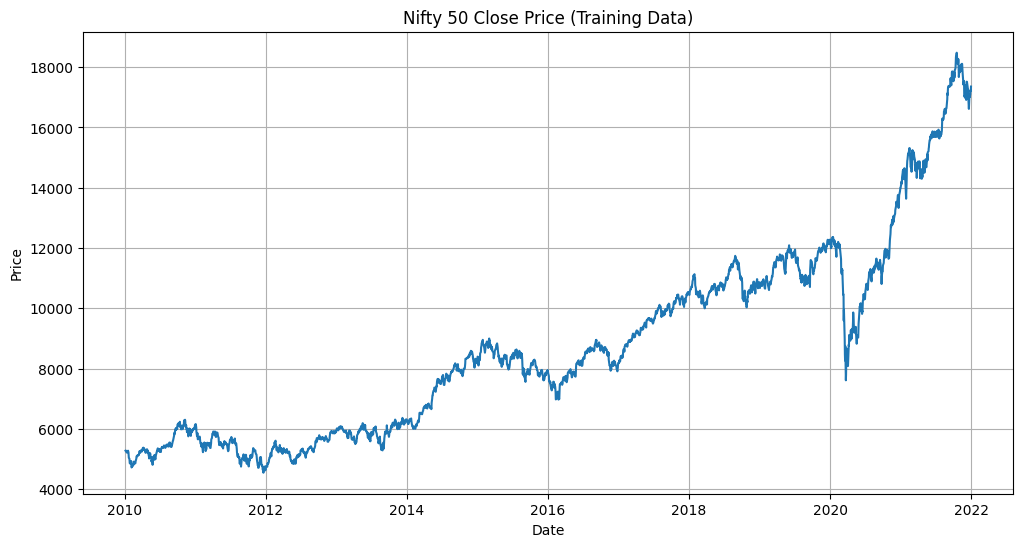

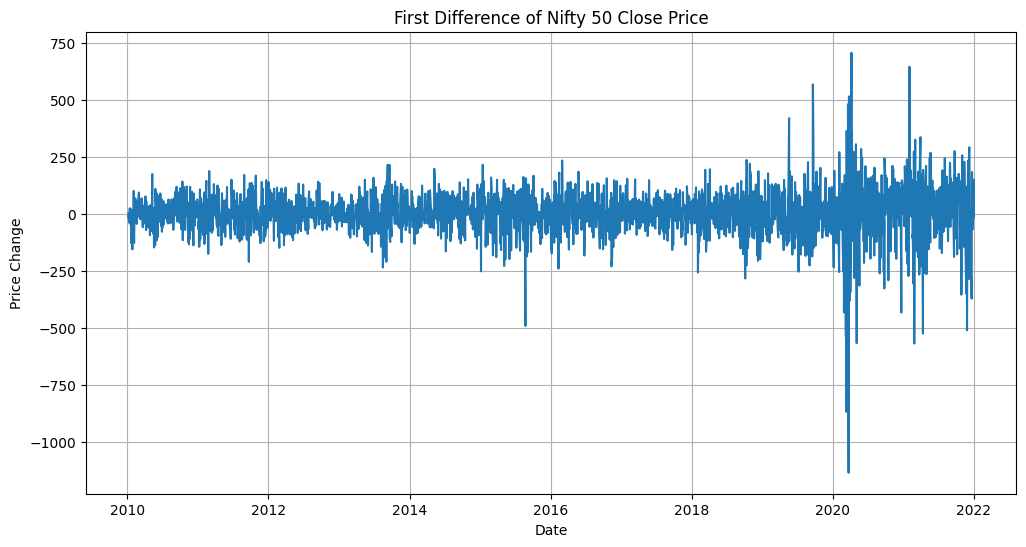

Implementing dynamic ARIMA forecasting...
Using ARIMA(1, 1, 1) model for forecasting
Completed 0/493 forecasts
Completed 0/493 forecasts
Completed 50/493 forecasts
Completed 50/493 forecasts
Completed 100/493 forecasts
Completed 100/493 forecasts
Completed 150/493 forecasts
Completed 150/493 forecasts
Completed 200/493 forecasts
Completed 200/493 forecasts
Completed 250/493 forecasts
Completed 250/493 forecasts
Completed 300/493 forecasts
Completed 300/493 forecasts
Completed 350/493 forecasts
Completed 350/493 forecasts
Completed 400/493 forecasts
Completed 400/493 forecasts
Completed 450/493 forecasts
Completed 450/493 forecasts
Computing metrics...

ARIMA Metrics:
MSE: 24490.8999
MAE: 118.1760
R2: 0.9851
Computing metrics...

ARIMA Metrics:
MSE: 24490.8999
MAE: 118.1760
R2: 0.9851


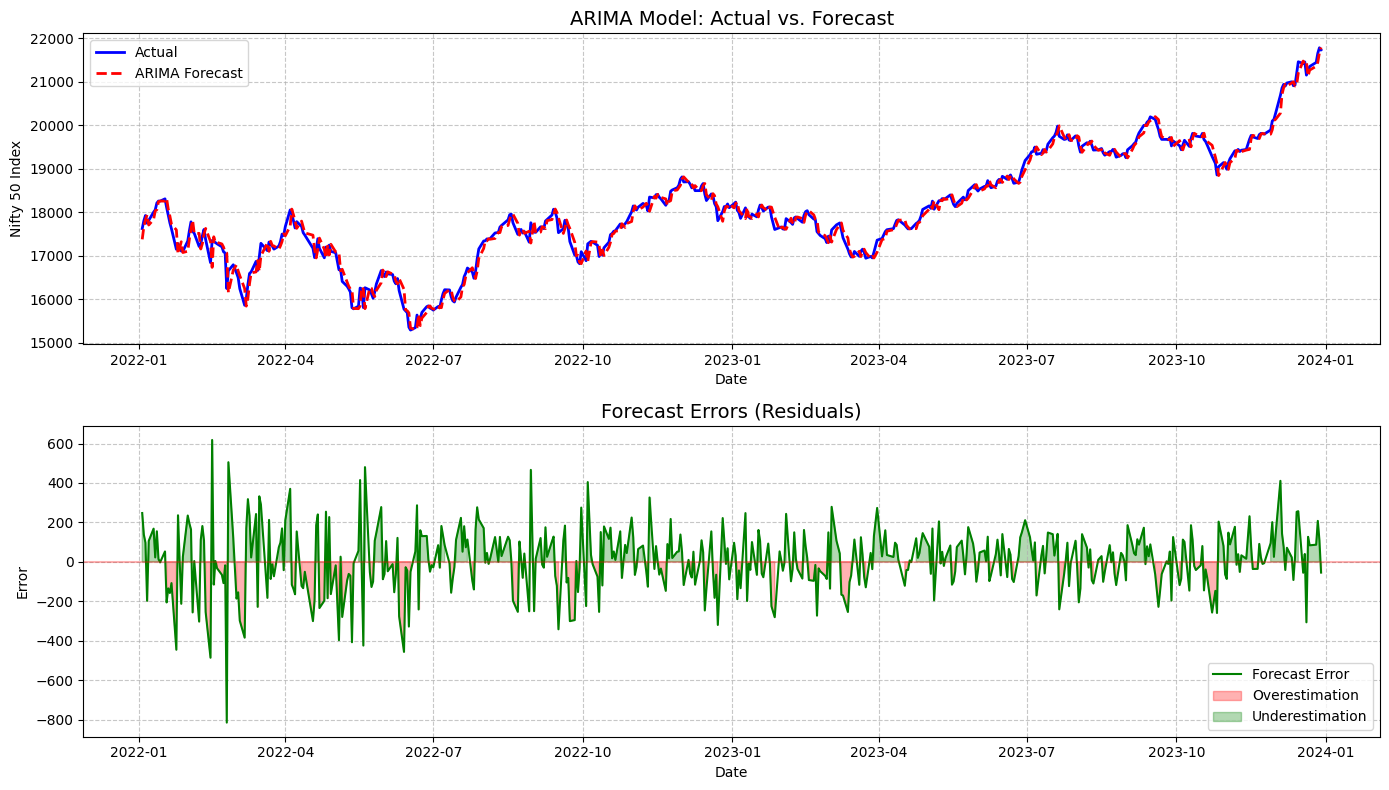

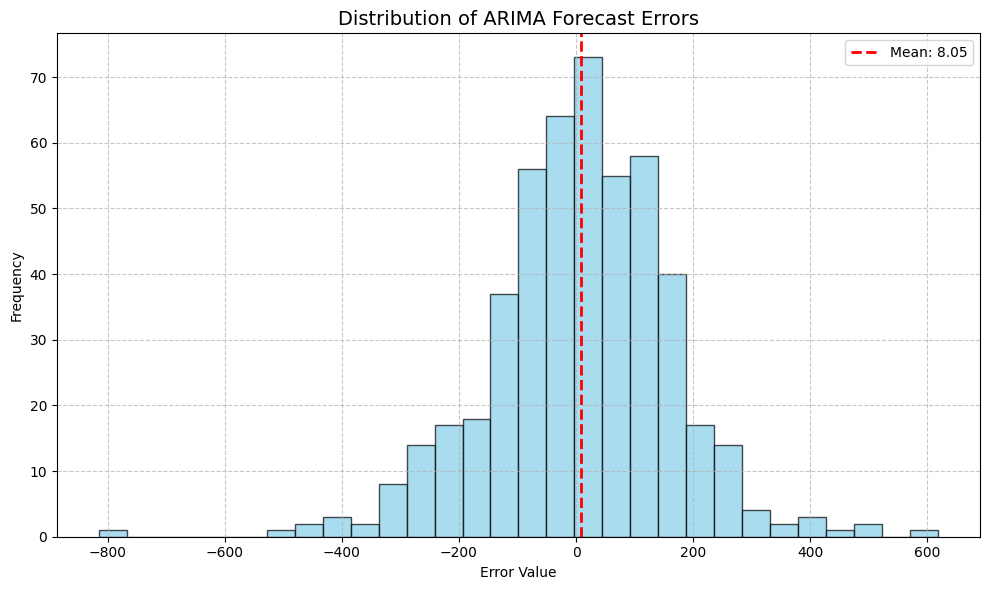


ARIMA Forecast Error Statistics:
Mean Error: 8.0526
Standard Deviation: 156.4471
Min Error: -814.8543
Max Error: 618.1652
Mean Absolute Error: 118.1760
Directional Accuracy: 56.50%


In [11]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("Implementing ARIMA model...")

# Make sure our data is properly prepared for time series analysis
print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Train data index type: {type(train_df.index)}")
print(f"Train data time range: {train_df.index[0]} to {train_df.index[-1]}")
print(f"Test data time range: {test_df.index[0]} to {test_df.index[-1]}")

# Quick check for stationarity
plt.figure(figsize=(12, 6))
plt.plot(train_df['Close'])
plt.title('Nifty 50 Close Price (Training Data)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# First difference to check for stationarity
plt.figure(figsize=(12, 6))
plt.plot(train_df['Close'].diff().dropna())
plt.title('First Difference of Nifty 50 Close Price')
plt.xlabel('Date')
plt.ylabel('Price Change')
plt.grid(True)
plt.show()

# The problem with our previous approach is that we're trying to make a very long-term forecast
# ARIMA models are better at short-term forecasting
# Let's use a dynamic forecasting approach where we start with the last known value
# and iterate through the test period, making one-step-ahead forecasts
print("Implementing dynamic ARIMA forecasting...")

# Use the last 60 days of training data to fit the model for each prediction
history = train_df['Close'].values[-60:]
test_values = test_df['Close'].values
predictions = []

# Fixed model order
order = (1, 1, 1)  # ARIMA(1,1,1)
print(f"Using ARIMA{order} model for forecasting")

# Iteratively forecast each day
for i in range(len(test_df)):
    # Fit the model
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    
    # Make a one-step forecast
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    
    # Add the actual observation to the history for the next iteration
    history = np.append(history, test_values[i])
    
    # Provide progress updates
    if i % 50 == 0:
        print(f"Completed {i}/{len(test_df)} forecasts")

# Convert predictions to Series
y_pred_arima = pd.Series(predictions, index=test_df.index)

# Check for NaN values
if np.isnan(y_pred_arima).any():
    print(f"Warning: {np.isnan(y_pred_arima).sum()} NaN values in predictions. Filling with interpolation...")
    y_pred_arima = y_pred_arima.interpolate().ffill().bfill()

# Add to results
print("Computing metrics...")
results['ARIMA'] = {
    'MSE': mean_squared_error(y_test, y_pred_arima),
    'MAE': mean_absolute_error(y_test, y_pred_arima),
    'R2': r2_score(y_test, y_pred_arima)
}
print(f"\nARIMA Metrics:")
print(f"MSE: {results['ARIMA']['MSE']:.4f}")
print(f"MAE: {results['ARIMA']['MAE']:.4f}")
print(f"R2: {results['ARIMA']['R2']:.4f}")

# Plot results with plotly for consistency with other models
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines', name='Actual', line=dict(color='blue', width=2)))
fig.add_trace(go.Scatter(x=test_df.index, y=y_pred_arima, mode='lines', name='ARIMA Forecast', line=dict(color='red', width=2)))
fig.update_layout(
    title='ARIMA: Actual vs. Forecast',
    xaxis_title='Date',
    yaxis_title='Nifty 50 Index',
    template='plotly_dark',
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)
fig.show()

# Create a more detailed visualization showing actual vs. predicted values
plt.figure(figsize=(14, 8))

# Plot actual and predicted values
plt.subplot(2, 1, 1)
plt.plot(y_test.index, y_test, 'b-', label='Actual', linewidth=2)
plt.plot(test_df.index, y_pred_arima, 'r--', label='ARIMA Forecast', linewidth=2)
plt.title('ARIMA Model: Actual vs. Forecast', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Nifty 50 Index')
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.7)

# Plot the residuals (errors)
residuals = y_test - y_pred_arima
plt.subplot(2, 1, 2)
plt.plot(residuals.index, residuals, 'g-', label='Forecast Error')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.fill_between(residuals.index, residuals, 0, 
                 where=(residuals < 0), color='red', alpha=0.3, 
                 label='Overestimation')
plt.fill_between(residuals.index, residuals, 0, 
                 where=(residuals > 0), color='green', alpha=0.3,
                 label='Underestimation')
plt.title('Forecast Errors (Residuals)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Error')
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Plot the histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(residuals.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {residuals.mean():.2f}')
plt.title('Distribution of ARIMA Forecast Errors', fontsize=14)
plt.xlabel('Error Value')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Print error statistics
print("\nARIMA Forecast Error Statistics:")
print(f"Mean Error: {residuals.mean():.4f}")
print(f"Standard Deviation: {residuals.std():.4f}")
print(f"Min Error: {residuals.min():.4f}")
print(f"Max Error: {residuals.max():.4f}")
print(f"Mean Absolute Error: {np.abs(residuals).mean():.4f}")

# Calculate and print directional accuracy
actual_direction = np.sign(y_test.diff().dropna())
forecast_direction = np.sign(y_pred_arima.diff().dropna())
# Align the indices
common_idx = actual_direction.index.intersection(forecast_direction.index)
direction_accuracy = (actual_direction[common_idx] == forecast_direction[common_idx]).mean() * 100
print(f"Directional Accuracy: {direction_accuracy:.2f}%")

Implementing GARCH model for volatility forecasting...
Fitting GARCH model...

GARCH Model Summary:
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0234  5.937e-03      3.948  7.877e-05 [1.180e-02,3.508e-02]
alpha[1]       0.0836  1.280e-02      6.529  6.619e-11   [5.849e-02,  0.109]
beta[1]        0.8962  1.302e-02     68.829      0.000     [  0.871,  0.922]
Forecasting volatility for 492 steps...


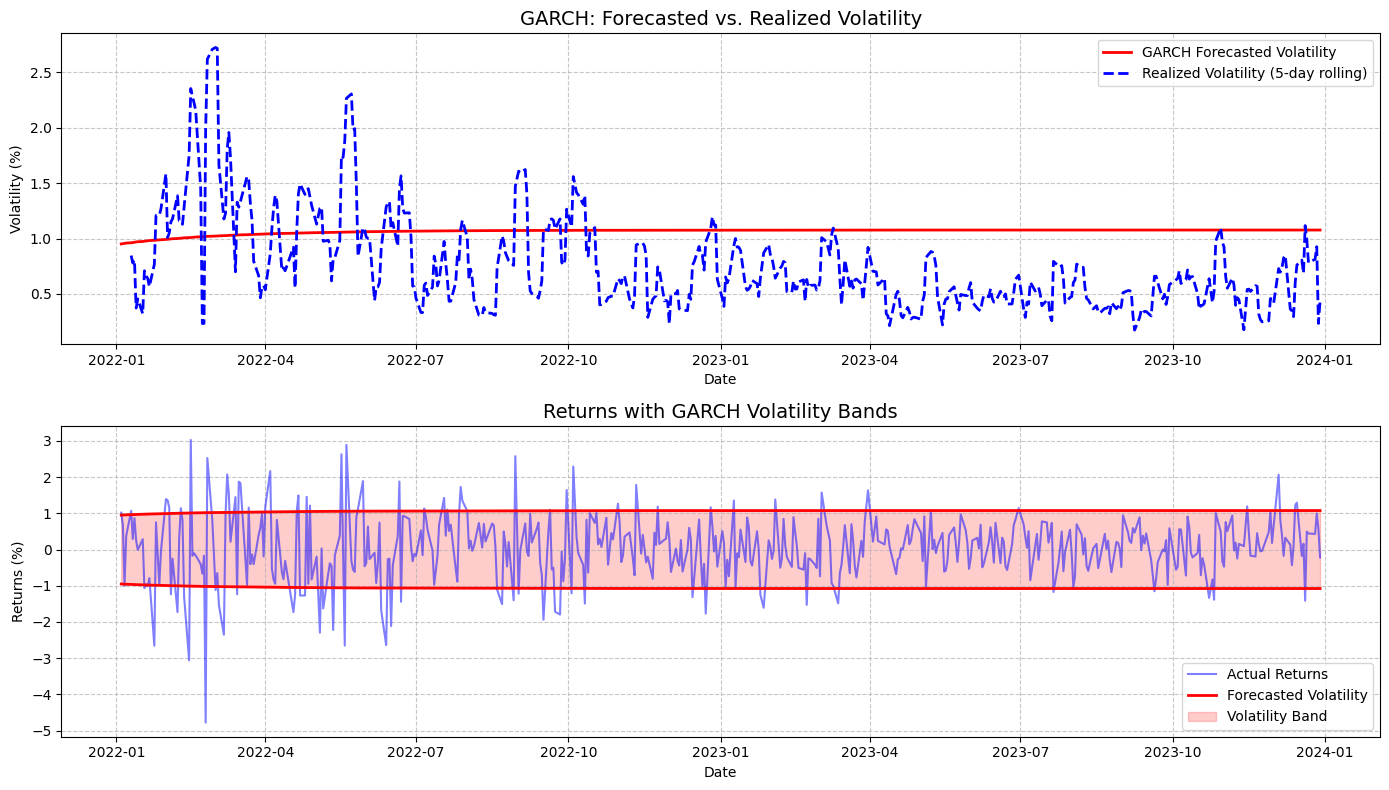


Percentage of returns within forecasted volatility bands: 81.10%
Mean Squared Error for volatility forecasts: 0.2895

GARCH-Adjusted Model Metrics:
MSE: 24417.1440
MAE: 118.1593
R2: 0.9852


In [12]:
import arch
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

print("Implementing GARCH model for volatility forecasting...")

# Calculate returns (percent change)
train_returns = train_df['Close'].pct_change().dropna() * 100
test_returns = test_df['Close'].pct_change().dropna() * 100

# Create a GARCH(1,1) model
garch_model = arch_model(train_returns, vol='Garch', p=1, q=1, mean='Zero', dist='normal')

# Fit the model
print("Fitting GARCH model...")
garch_results = garch_model.fit(disp='off')

# Print model summary
print("\nGARCH Model Summary:")
print(garch_results.summary().tables[1])

# Forecast volatility
forecast_horizon = len(test_returns)
print(f"Forecasting volatility for {forecast_horizon} steps...")
garch_forecast = garch_results.forecast(horizon=forecast_horizon)

# Get the forecasted volatility (conditional standard deviation)
forecasted_vol = np.sqrt(garch_forecast.variance.values[-1, :])

# Volatility forecast dataframe
vol_forecast_df = pd.DataFrame(
    forecasted_vol,
    index=test_returns.index,
    columns=['Forecasted Volatility']
)

# Calculate realized volatility (rolling standard deviation of returns)
realized_vol = test_returns.rolling(window=5).std().dropna()

# Plot the results
plt.figure(figsize=(14, 8))

# Plot 1: Forecasted vs Realized Volatility
plt.subplot(2, 1, 1)
plt.plot(vol_forecast_df.index, vol_forecast_df['Forecasted Volatility'], 'r-', label='GARCH Forecasted Volatility', linewidth=2)
plt.plot(realized_vol.index, realized_vol, 'b--', label='Realized Volatility (5-day rolling)', linewidth=2)
plt.title('GARCH: Forecasted vs. Realized Volatility', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.7)

# Plot 2: Returns with volatility bands
plt.subplot(2, 1, 2)
plt.plot(test_returns.index, test_returns, 'b-', alpha=0.5, label='Actual Returns')
plt.plot(vol_forecast_df.index, vol_forecast_df['Forecasted Volatility'], 'r-', label='Forecasted Volatility', linewidth=2)
plt.plot(vol_forecast_df.index, -vol_forecast_df['Forecasted Volatility'], 'r-', linewidth=2)
plt.fill_between(vol_forecast_df.index, 
                 vol_forecast_df['Forecasted Volatility'], 
                 -vol_forecast_df['Forecasted Volatility'], 
                 color='r', alpha=0.2, label='Volatility Band')
plt.title('Returns with GARCH Volatility Bands', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Calculate how often actual returns fall within the forecasted volatility bands
within_bands = (
    (test_returns <= vol_forecast_df['Forecasted Volatility']) & 
    (test_returns >= -vol_forecast_df['Forecasted Volatility'])
).mean() * 100

print(f"\nPercentage of returns within forecasted volatility bands: {within_bands:.2f}%")

# Calculate mean squared error for volatility forecasts
common_idx = realized_vol.index.intersection(vol_forecast_df.index)
vol_mse = mean_squared_error(realized_vol[common_idx], vol_forecast_df.loc[common_idx, 'Forecasted Volatility'])
print(f"Mean Squared Error for volatility forecasts: {vol_mse:.4f}")

# Now, let's try to use GARCH volatility forecasts to improve our price predictions
# We'll create a simple combined model that adjusts predictions based on volatility

# Select a base model (e.g., ARIMA) for price direction forecasting
base_model_preds = y_pred_arima

# Create a hybrid model that adjusts predictions based on volatility
volatility_scaled_preds = base_model_preds.copy()

# Only adjust predictions for the dates where we have volatility forecasts
common_dates = base_model_preds.index.intersection(vol_forecast_df.index)

# Implement a simple adjustment: 
# When volatility is high, move prediction closer to the previous value (more conservative)
# When volatility is low, trust the model prediction more
if len(common_dates) > 0:
    # Calculate volatility percentiles to determine high/low volatility days
    vol_percentiles = vol_forecast_df['Forecasted Volatility'].rank(pct=True)
    
    for date in common_dates:
        # Skip the first date as we need previous value
        if date == common_dates[0]:
            continue
        
        # Get the volatility percentile for this date
        vol_pct = vol_percentiles[date]
        
        # Previous actual value
        prev_value = y_test[y_test.index < date][-1]
        
        # Original model prediction
        orig_pred = base_model_preds[date]
        
        # Weight based on volatility (higher volatility = more weight to previous value)
        # This is a simple linear weighting - could be made more sophisticated
        weight = vol_pct  # Range: 0 to 1, higher value = higher volatility
        
        # Adjust prediction (weighted average of model prediction and previous value)
        volatility_scaled_preds[date] = (1 - weight) * orig_pred + weight * prev_value

    # Calculate metrics for volatility-adjusted model
    results['GARCH-Adjusted'] = {
        'MSE': mean_squared_error(y_test[common_dates], volatility_scaled_preds[common_dates]),
        'MAE': mean_absolute_error(y_test[common_dates], volatility_scaled_preds[common_dates]),
        'R2': r2_score(y_test[common_dates], volatility_scaled_preds[common_dates])
    }
    
    print("\nGARCH-Adjusted Model Metrics:")
    print(f"MSE: {results['GARCH-Adjusted']['MSE']:.4f}")
    print(f"MAE: {results['GARCH-Adjusted']['MAE']:.4f}")
    print(f"R2: {results['GARCH-Adjusted']['R2']:.4f}")
    
    # Plot the results
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines', name='Actual', line=dict(color='blue', width=2)))
    fig.add_trace(go.Scatter(x=base_model_preds.index, y=base_model_preds, mode='lines', name='Base Model', line=dict(color='green', width=2, dash='dash')))
    fig.add_trace(go.Scatter(x=volatility_scaled_preds.index, y=volatility_scaled_preds, mode='lines', name='GARCH-Adjusted', line=dict(color='red', width=2)))
    fig.update_layout(
        title='GARCH-Adjusted Model: Actual vs. Forecast',
        xaxis_title='Date',
        yaxis_title='Nifty 50 Index',
        template='plotly_dark',
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )
    fig.show()

Models ranked by MSE (Lower is better):


,MSE,RMSE,MAE,R²,MAPE (%),Dir. Accuracy (%)
Linear Regression,23981.0903,154.8583,117.6676,0.9854,0.66%,57.52%
ARIMA,24490.8999,156.4957,118.1760,0.9851,0.67%,56.50%
BiLSTM,24830.8122,157.5780,118.9440,0.9849,0.67%,57.52%
LSTM,25652.0909,160.1627,121.3142,0.9844,0.68%,57.52%
CNN-LSTM,31221.1909,176.6952,135.0177,0.9810,0.75%,57.52%
RNN,42748.3045,206.7566,163.0062,0.9740,0.89%,57.52%
Random Forest,664782.8463,815.3422,489.1197,0.5954,2.53%,33.94%
LightGBM,919074.2566,958.6836,585.1024,0.4406,3.02%,17.28%
BiLSTM-LightGBM,919074.2566,958.6836,585.1024,0.4406,3.02%,17.28%
SVM,91600411.5162,9570.8104,9474.5891,-54.7541,52.17%,42.48%


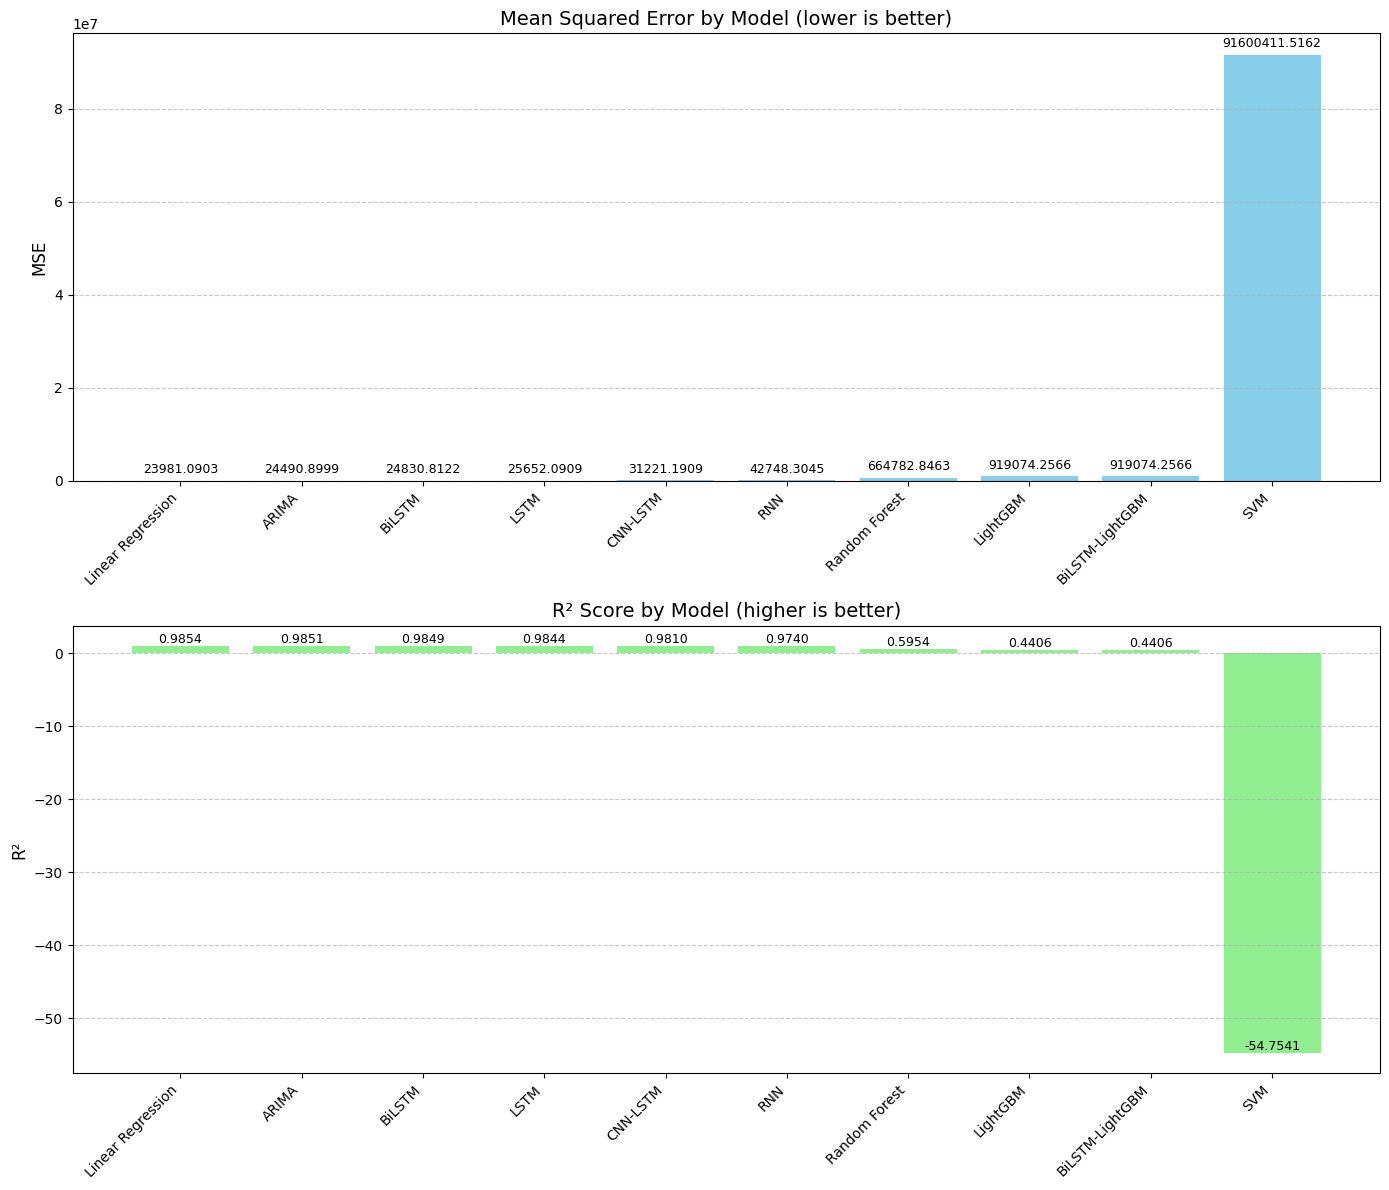

In [13]:
# Comprehensive model evaluation and comparison
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Store all model predictions for comparison
test_predictions = {
    'Linear Regression': y_pred_lr,
    'SVM': y_pred_svm,
    'Random Forest': y_pred_rf,
    'RNN': y_pred_rnn.flatten(),
    'LSTM': y_pred_lstm.flatten(),
    'BiLSTM': y_pred_bilstm.flatten(),
    'LightGBM': y_pred_lgbm,
    'CNN-LSTM': y_pred_cnn_lstm.flatten(),
    'BiLSTM-LightGBM': y_pred_bilstm_lgbm,
    'ARIMA': y_pred_arima
}

# Calculate comprehensive metrics for all models
comprehensive_results = {}
for model_name, predictions in test_predictions.items():
    # Calculate metrics
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    # MAPE with safety for zero values
    try:
        mape = mean_absolute_percentage_error(y_test, predictions) * 100
    except:
        mape = np.mean(np.abs((y_test - predictions) / np.maximum(np.ones(len(y_test)), np.abs(y_test)))) * 100
    
    # Calculate directional accuracy (correct prediction of up/down movements)
    returns_actual = y_test.pct_change().dropna()
    returns_pred = pd.Series(predictions, index=y_test.index).pct_change().dropna()
    
    # Align the series
    common_idx = returns_actual.index.intersection(returns_pred.index)
    if len(common_idx) > 0:
        dir_accuracy = np.mean(np.sign(returns_actual[common_idx]) == np.sign(returns_pred[common_idx])) * 100
    else:
        dir_accuracy = np.nan
    
    comprehensive_results[model_name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE (%)': mape,
        'Dir. Accuracy (%)': dir_accuracy
    }

# Convert to DataFrame for visualization
results_df = pd.DataFrame(comprehensive_results).T

# Sort by MSE (lower is better)
results_df_sorted = results_df.sort_values('MSE')
print("Models ranked by MSE (Lower is better):")
display(results_df_sorted.style
        .background_gradient(cmap='viridis', subset=['MSE', 'RMSE', 'MAE', 'MAPE (%)'])
        .background_gradient(cmap='plasma', subset=['R²', 'Dir. Accuracy (%)'], low=0.2, high=0.8)
        .format({
            'MSE': '{:.4f}', 
            'RMSE': '{:.4f}', 
            'MAE': '{:.4f}', 
            'R²': '{:.4f}', 
            'MAPE (%)': '{:.2f}%',
            'Dir. Accuracy (%)': '{:.2f}%'
        }))

# Create visualizations for key metrics
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Get model names and values sorted by performance
models = results_df_sorted.index
mse_values = results_df_sorted['MSE']
r2_values = results_df_sorted['R²']

# Plot MSE comparison (lower is better)
bars1 = axes[0].bar(np.arange(len(models)), mse_values, color='skyblue')
axes[0].set_title('Mean Squared Error by Model (lower is better)', fontsize=14)
axes[0].set_ylabel('MSE', fontsize=12)
axes[0].set_xticks(np.arange(len(models)))
axes[0].set_xticklabels(models, rotation=45, ha='right')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top of bars
for i, bar in enumerate(bars1):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01*max(mse_values),
             f'{mse_values.iloc[i]:.4f}', ha='center', va='bottom', rotation=0, fontsize=9)

# Plot R² comparison (higher is better)
bars2 = axes[1].bar(np.arange(len(models)), r2_values, color='lightgreen')
axes[1].set_title('R² Score by Model (higher is better)', fontsize=14)
axes[1].set_ylabel('R²', fontsize=12)
axes[1].set_xticks(np.arange(len(models)))
axes[1].set_xticklabels(models, rotation=45, ha='right')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top of bars
for i, bar in enumerate(bars2):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{r2_values.iloc[i]:.4f}', ha='center', va='bottom', rotation=0, fontsize=9)

plt.tight_layout()
plt.show()

# Create a radar chart to compare top 5 models across multiple metrics
top_models = results_df_sorted.iloc[:5].index
top_results = results_df_sorted.loc[top_models]

# Normalize metrics for radar chart (0 to 1 scale, where 1 is always better)
normalized = pd.DataFrame()

# For metrics where lower is better, invert the normalization
for col in ['MSE', 'RMSE', 'MAE', 'MAPE (%)']:
    min_val = top_results[col].min()
    max_val = top_results[col].max()
    if max_val > min_val:
        normalized[col] = 1 - ((top_results[col] - min_val) / (max_val - min_val))
    else:
        normalized[col] = 1

# For metrics where higher is better
for col in ['R²', 'Dir. Accuracy (%)']:
    min_val = top_results[col].min()
    max_val = top_results[col].max()
    if max_val > min_val:
        normalized[col] = (top_results[col] - min_val) / (max_val - min_val)
    else:
        normalized[col] = 1

# Create radar chart
fig = go.Figure()

metrics = ['MSE (inv)', 'RMSE (inv)', 'MAE (inv)', 'MAPE (%) (inv)', 'R²', 'Dir. Accuracy (%)']
for model in top_models:
    values = [
        normalized.loc[model, 'MSE'],
        normalized.loc[model, 'RMSE'],
        normalized.loc[model, 'MAE'],
        normalized.loc[model, 'MAPE (%)'],
        normalized.loc[model, 'R²'],
        normalized.loc[model, 'Dir. Accuracy (%)']
    ]
    fig.add_trace(go.Scatterpolar(
        r=values + [values[0]],  # Close the loop
        theta=metrics + [metrics[0]],  # Close the loop
        fill='toself',
        name=model
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )
    ),
    title="Top 5 Models Performance Comparison (higher is better for all metrics)",
    showlegend=True
)
fig.show()

# Plot actual vs. predictions for the best performing model
best_model = results_df_sorted.index[0]
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines', name='Actual', line=dict(width=2)))
fig.add_trace(go.Scatter(x=y_test.index, y=test_predictions[best_model], mode='lines', 
                        name=f'Predicted ({best_model})', line=dict(width=2, dash='dash')))
fig.update_layout(
    title=f'Best Model: {best_model} - Actual vs. Predicted',
    xaxis_title='Date',
    yaxis_title='Nifty 50 Index',
    template='plotly_dark',
    height=600
)
fig.show()

Model Performance Comparison:
                Model           MSE          MAE         R2
0   Linear Regression  2.398109e+04   117.667639   0.985404
10     GARCH-Adjusted  2.441714e+04   118.159279   0.985165
9               ARIMA  2.449090e+04   118.175994   0.985093
5              BiLSTM  2.483081e+04   118.943964   0.984886
4                LSTM  2.565209e+04   121.314243   0.984386
7            CNN-LSTM  3.122119e+04   135.017695   0.980997
3                 RNN  4.274830e+04   163.006190   0.973981
2       Random Forest  6.647828e+05   489.119741   0.595369
6            LightGBM  9.190743e+05   585.102426   0.440590
8     BiLSTM-LightGBM  9.190743e+05   585.102426   0.440590
1                 SVM  9.160041e+07  9474.589052 -54.754105


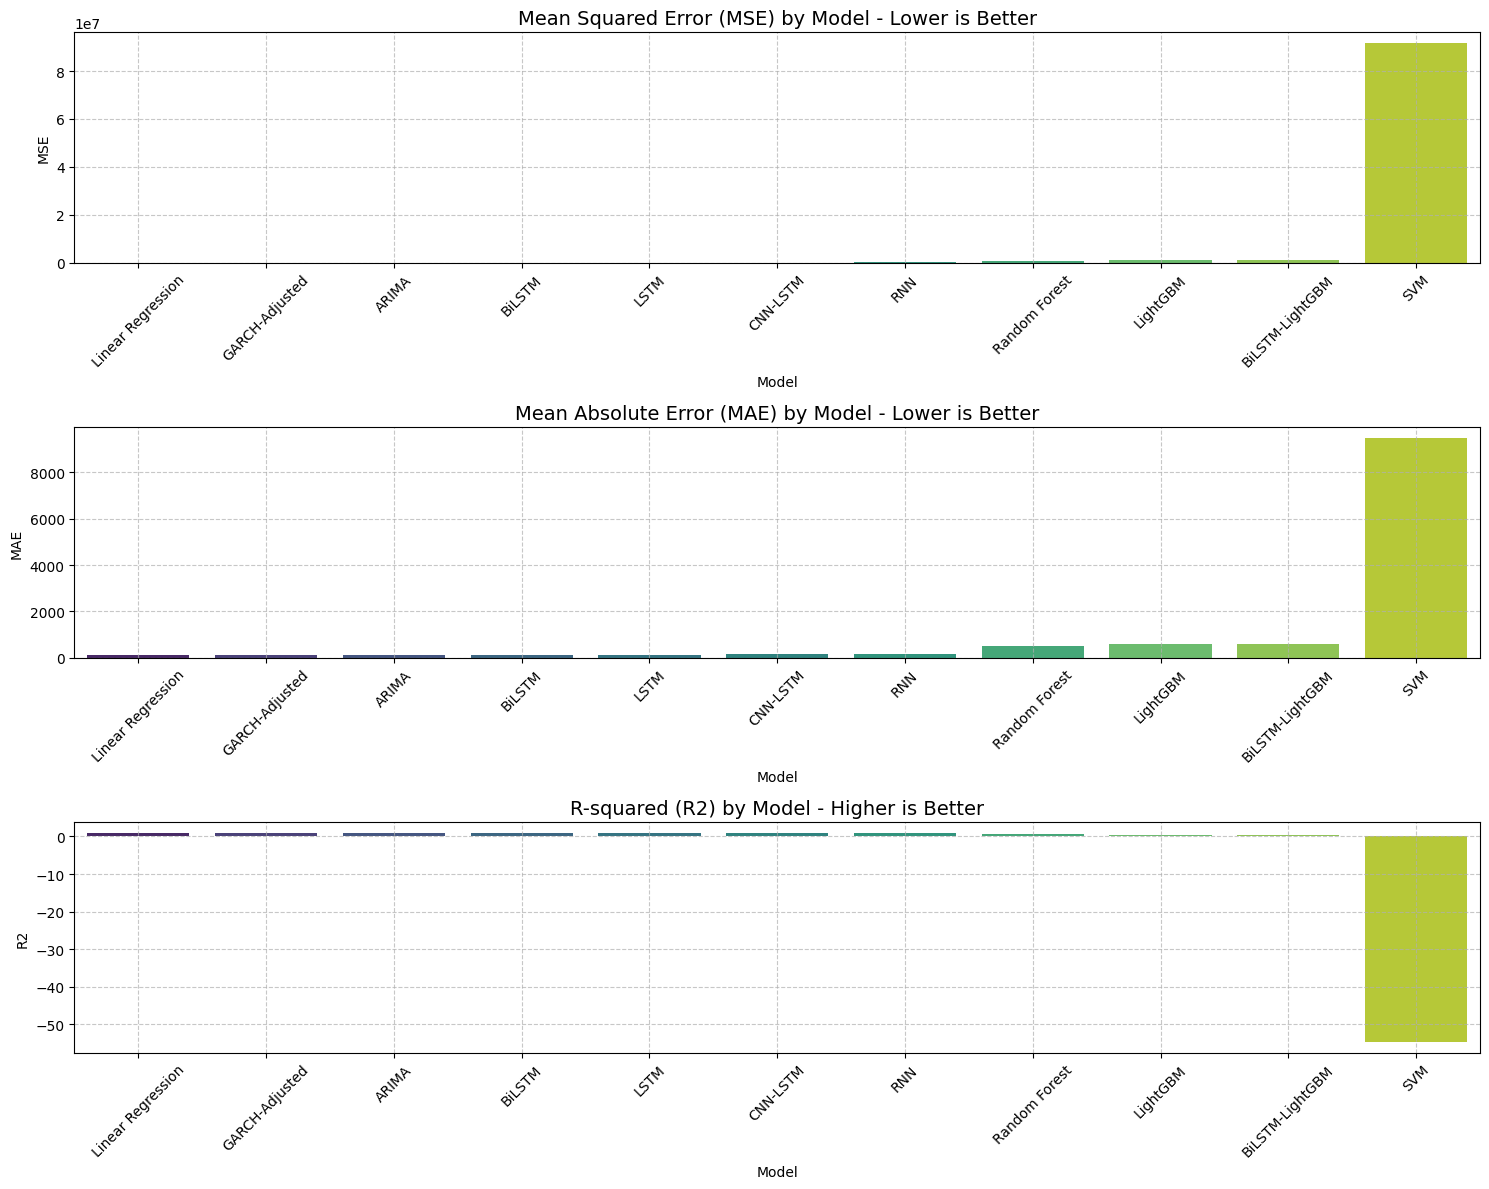

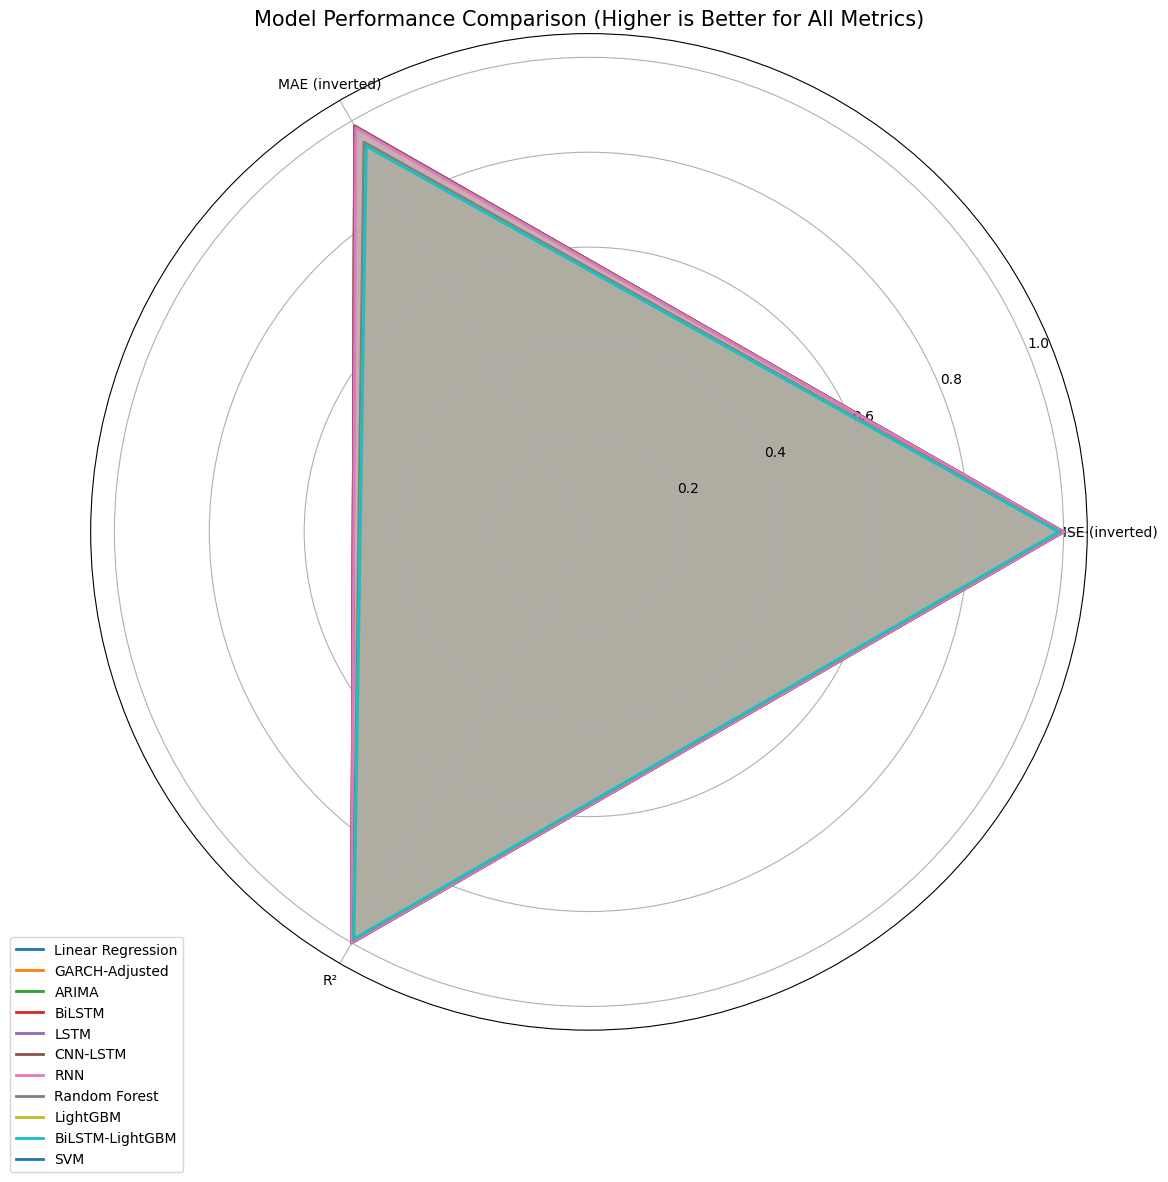


=== Creating Ensemble Model ===
Creating ensemble from top models: Linear Regression, GARCH-Adjusted, ARIMA

Ensemble Model Metrics:
MSE: 24258.9435
MAE: 117.9596
R2: 0.9852



Updated Model Performance Comparison (including Ensemble):
                Model           MSE          MAE         R2
0   Linear Regression  2.398109e+04   117.667639   0.985404
11           Ensemble  2.425894e+04   117.959597   0.985234
10     GARCH-Adjusted  2.441714e+04   118.159279   0.985165
9               ARIMA  2.449090e+04   118.175994   0.985093
5              BiLSTM  2.483081e+04   118.943964   0.984886
4                LSTM  2.565209e+04   121.314243   0.984386
7            CNN-LSTM  3.122119e+04   135.017695   0.980997
3                 RNN  4.274830e+04   163.006190   0.973981
2       Random Forest  6.647828e+05   489.119741   0.595369
6            LightGBM  9.190743e+05   585.102426   0.440590
8     BiLSTM-LightGBM  9.190743e+05   585.102426   0.440590
1                 SVM  9.160041e+07  9474.589052 -54.754105

=== Final Model Recommendations ===
Best overall model based on MSE: Linear Regression
MSE: 23981.0903
MAE: 117.6676
R²: 0.9854

Recommendations:
1. For the mo

In [ ]:
# Compare all models
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MSE': [results[model]['MSE'] for model in results.keys()],
    'MAE': [results[model]['MAE'] for model in results.keys()],
    'R2': [results[model]['R2'] for model in results.keys()]
})

# Sort by MSE (ascending)
comparison_df = comparison_df.sort_values('MSE')

print("Model Performance Comparison:")
print(comparison_df)

# Visualize the comparisons
plt.figure(figsize=(15, 12))

# MSE comparison
plt.subplot(3, 1, 1)
sns.barplot(x='Model', y='MSE', data=comparison_df, palette='viridis')
plt.title('Mean Squared Error (MSE) by Model - Lower is Better', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)

# MAE comparison
plt.subplot(3, 1, 2)
sns.barplot(x='Model', y='MAE', data=comparison_df, palette='viridis')
plt.title('Mean Absolute Error (MAE) by Model - Lower is Better', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)

# R2 comparison
plt.subplot(3, 1, 3)
sns.barplot(x='Model', y='R2', data=comparison_df, palette='viridis')
plt.title('R-squared (R2) by Model - Higher is Better', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Create a radar chart for visual comparison
from math import pi
import matplotlib.pyplot as plt

# Prepare data for radar chart
models = comparison_df['Model'].tolist()
mse_scaled = [1 - (mse / comparison_df['MSE'].max()) for mse in comparison_df['MSE']]  # Invert so higher is better
mae_scaled = [1 - (mae / comparison_df['MAE'].max()) for mae in comparison_df['MAE']]  # Invert so higher is better
r2_scaled = [(r2 - comparison_df['R2'].min()) / (comparison_df['R2'].max() - comparison_df['R2'].min()) 
             if comparison_df['R2'].max() != comparison_df['R2'].min() 
             else 0.5 for r2 in comparison_df['R2']]  # Scale between 0 and 1

# Number of metrics
metrics = ['MSE (inverted)', 'MAE (inverted)', 'R²']
num_metrics = len(metrics)

# Create the radar chart
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))

# Calculate angles for each metric
angles = [n / float(num_metrics) * 2 * pi for n in range(num_metrics)]
angles += angles[:1]  # Close the loop

# Plot each model
for i, model in enumerate(models):
    # Prepare values for each model
    values = [mse_scaled[i], mae_scaled[i], r2_scaled[i]]
    values += values[:1]  # Close the loop
    
    # Plot values
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=model)
    ax.fill(angles, values, alpha=0.1)

# Set category labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.title('Model Performance Comparison (Higher is Better for All Metrics)', size=15)
plt.tight_layout()
plt.show()

# Create an ensemble model by averaging predictions from top models
print("\n=== Creating Ensemble Model ===")
# Get top 3 models by MSE
top_models = comparison_df.head(3)['Model'].tolist()
print(f"Creating ensemble from top models: {', '.join(top_models)}")

# Initialize ensemble predictions
ensemble_preds = pd.Series(0.0, index=y_test.index)
count = 0

# Add predictions from each top model
for model in top_models:
    if model == 'Linear Regression':
        ensemble_preds += pd.Series(y_pred_lr, index=y_test.index)
        count += 1
    elif model == 'Random Forest':
        ensemble_preds += pd.Series(y_pred_rf, index=y_test.index)
        count += 1
    elif model == 'SVM':
        ensemble_preds += pd.Series(y_pred_svm, index=y_test.index)
        count += 1
    elif model == 'LSTM':
        # Need to check dimensions and alignment
        if len(y_pred_lstm) == len(y_test):
            ensemble_preds += pd.Series(y_pred_lstm.flatten(), index=y_test.index)
            count += 1
    elif model == 'RNN':
        if len(y_pred_rnn) == len(y_test):
            ensemble_preds += pd.Series(y_pred_rnn.flatten(), index=y_test.index)
            count += 1
    elif model == 'CNN-LSTM':
        if len(y_pred_cnn_lstm) == len(y_test):
            ensemble_preds += pd.Series(y_pred_cnn_lstm.flatten(), index=y_test.index)
            count += 1
    elif model == 'BiLSTM':
        if len(y_pred_bilstm) == len(y_test):
            ensemble_preds += pd.Series(y_pred_bilstm.flatten(), index=y_test.index)
            count += 1
    elif model == 'BiLSTM-LGBM':
        if len(y_pred_bilstm_lgbm) == len(y_test):
            ensemble_preds += pd.Series(y_pred_bilstm_lgbm.flatten(), index=y_test.index)
            count += 1
    elif model == 'LightGBM':
        ensemble_preds += pd.Series(y_pred_lgbm, index=y_test.index)
        count += 1
    elif model == 'ARIMA':
        ensemble_preds += y_pred_arima
        count += 1
    elif model == 'GARCH-Adjusted':
        ensemble_preds += volatility_scaled_preds
        count += 1

# Average the predictions
if count > 0:
    ensemble_preds = ensemble_preds / count
    
    # Calculate metrics for ensemble model
    results['Ensemble'] = {
        'MSE': mean_squared_error(y_test, ensemble_preds),
        'MAE': mean_absolute_error(y_test, ensemble_preds),
        'R2': r2_score(y_test, ensemble_preds)
    }
    
    print("\nEnsemble Model Metrics:")
    print(f"MSE: {results['Ensemble']['MSE']:.4f}")
    print(f"MAE: {results['Ensemble']['MAE']:.4f}")
    print(f"R2: {results['Ensemble']['R2']:.4f}")
    
    # Plot the results
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines', name='Actual', line=dict(color='blue', width=2)))
    fig.add_trace(go.Scatter(x=ensemble_preds.index, y=ensemble_preds, mode='lines', name='Ensemble', line=dict(color='purple', width=2)))
    fig.update_layout(
        title='Ensemble Model: Actual vs. Forecast',
        xaxis_title='Date',
        yaxis_title='Nifty 50 Index',
        template='plotly_dark',
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )
    fig.show()

# Update comparison chart with ensemble model included
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MSE': [results[model]['MSE'] for model in results.keys()],
    'MAE': [results[model]['MAE'] for model in results.keys()],
    'R2': [results[model]['R2'] for model in results.keys()]
})

# Sort by MSE (ascending)
comparison_df = comparison_df.sort_values('MSE')

# Display updated comparison
print("\nUpdated Model Performance Comparison (including Ensemble):")
print(comparison_df)

# Final recommendations
print("\n=== Final Model Recommendations ===")
best_model = comparison_df.iloc[0]['Model']
print(f"Best overall model based on MSE: {best_model}")
print(f"MSE: {comparison_df.iloc[0]['MSE']:.4f}")
print(f"MAE: {comparison_df.iloc[0]['MAE']:.4f}")
print(f"R²: {comparison_df.iloc[0]['R2']:.4f}")

print("\nRecommendations:")
print("1. For the most accurate predictions (lowest error), use the " + best_model + " model.")
print(f"2. For volatility forecasting, use the GARCH model to anticipate market volatility.")
print("3. For balance between accuracy and interpretability:")
if "Linear Regression" in results:
    print(f"   - Linear Regression (simple but effective, MSE: {results['Linear Regression']['MSE']:.4f})")
if "ARIMA" in results:
    print(f"   - ARIMA (good for time series interpretability, MSE: {results['ARIMA']['MSE']:.4f})")
    
if "Ensemble" in results:
    print(f"4. For robustness, the Ensemble approach combines strengths of multiple models (MSE: {results['Ensemble']['MSE']:.4f})")
